In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.autograd import Variable
import random

In [32]:
df = pd.read_csv("../data/interim/small_10000_orders_weighted_adjacency_matrix.csv")
df.head()

,user_id,product_id,weight
0,55623,878,7
1,55623,1463,2
2,55623,2344,2
3,55623,3339,3
4,55623,3566,1


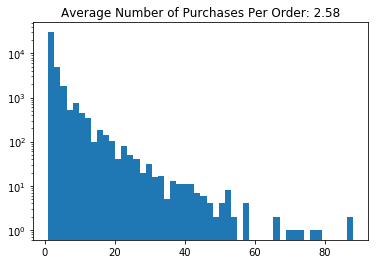

In [33]:
plt.hist(df.weight, bins=50)
plt.yscale('log')
plt.title(f"Average Number of Purchases Per Order: {df.weight.mean():.2f}")
plt.show()

In [34]:
df_grouped = df[["product_id", "weight"]].groupby(["product_id"]).sum()
df_grouped.reset_index(inplace=True)
df_grouped.sort_values(by="weight", ascending=False).head(10)

,product_id,weight
3169,13176,1307
5904,24852,1305
5228,21903,963
5032,21137,861
11221,47209,785
6225,26209,525
6637,27966,478
11335,47766,471
4015,16797,449
11308,47626,419


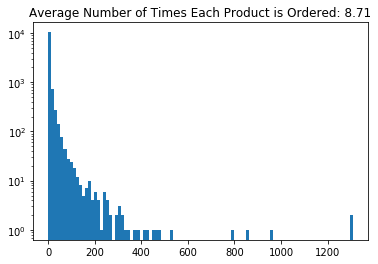

In [35]:
plt.hist(df_grouped.weight, bins=100)
plt.title(f"Average Number of Times Each Product is Ordered: {df_grouped.weight.mean():.2f}")
plt.yscale('log')
plt.show()

## Collaborative Filtering

Our goal is to create embedding matrices for users, and products in a low-dimensional
latent space. In the user-product matrix, instead of weights, we will just indicate
if there was a prior purchase with a 1, and no previous purchase with a 0.

In [52]:
df["interaction"] = (df.weight/df.weight).astype(int)

For the models we will want to use a numberic index rather than the product_id and user_id so that we can easily match the embedding vector with the user or product.

In [62]:
def idx2id(id_list):
    return dict(enumerate(sorted(set(id_list))))

In [65]:
idx2product = idx2id(df.product_id)
idx2user = idx2id(df.user_id)

product2idx = {key: value for value, key in idx2product.items()}
user2idx = {key: value for value, key in idx2user.items()}

In [ ]:
# this takes a little bit of time
df.user_id = df.user_id.replace(user2idx)
df.product_id = df.product_id.replace(product2idx)

In [ ]:
# creating the training, validation, and testing protion of the datasets.
X_train, X_test, y_train, y_test = train_test_split(df[["user_id", "product_id"]], df.interaction, 
                                                    test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test,
                                                test_size=0.5, random_state=22)

In [61]:
train_products, train_users = 
val_products, val_users = id2idx(X_val.user_id)
test_products, test_users = id2idx(X_test.user_id)

In [ ]:
class MatrixFactorization(nn.Module):
    """
    
    """
    def __init__(self, n_users, n_products, n_factors=20):
        """
        
        """
        super(MatrixFactorization).__init__()
        # create embeddings
        self.user_factors = nn.Embedding(n_users, n_factors, sparse=True)
        self.product_factors = nn.Embedding(n_products, n_factors, sparse=True)

    def forward(self, user, product):
        # matrix multiplication
        return (self.user_factors(user) * self.product_factors(item)).sum(1)

    def predict(self, user, product):
        return 1 if self.forward(user, item) >= 0.5 else 0

In [ ]:
n_users, n_products = len(user2idx), len(product2idx)

model = MatrixFactorization(n_users, n_products, n_factors=20)
loss_fn = torch.nn.MSELoss() 
optimizer = torch.optim.SGD(model.parameters(),
                            lr=1e-6)

for user, item in zip(users, items):
    # get user, item and rating data
    rating = Variable(torch.FloatTensor([ratings[user, item]]))
    user = Variable(torch.LongTensor([int(user)]))
    item = Variable(torch.LongTensor([int(item)]))

    # predict
    prediction = model(user, item)
    loss = loss_fn(prediction, rating)

    # backpropagate
    loss.backward()

    # update weights
    optimizer.step()

In [ ]:
# neural net based on Embedding matrices
# model reference -> https://github.com/fastai/fastai/
class EmbeddingModel(nn.Module):
    def __init__(self, n_factors, n_users, n_items, y_range, initialise = 0.01):
        super().__init__()
        self.y_range = y_range
        self.u_weight = nn.Embedding(n_users, n_factors)
        self.i_weight = nn.Embedding(n_items, n_factors)
        self.u_bias = nn.Embedding(n_users, 1)
        self.i_bias = nn.Embedding(n_items, 1)
        
        # initialise the weights of the embeddings
        self.u_weight.weight.data.uniform_(-initialise, initialise)
        self.i_weight.weight.data.uniform_(-initialise, initialise)
        self.u_bias.weight.data.uniform_(-initialise, initialise)
        self.i_bias.weight.data.uniform_(-initialise, initialise)

    def forward(self, users, items):
        # dot multiply the weights for the given user_id and item_id
        dot = self.u_weight(users)* self.i_weight(items)
        
        # sum the result of dot multiplication above and add both the bias terms
        res = dot.sum(1) + self.u_bias(users).squeeze() + self.i_bias(items).squeeze()
        
        # return the output in the given range
        return torch.sigmoid(res) * (self.y_range[1]-self.y_range[0]) + self.y_range[0]

    
# create a model object
# y_range has been extended(0-11) than required(1-10) to make the
# values lie in the linear region of the sigmoid function
model = EmbeddingModel(10, len(users), len(items), [0,11], initialise = 0.01).cuda()

# split the data, returns a list [train, valid]
data = get_data(ratings, 0.1)

# loss = mean((target_rating - predicted_rating)**2)
loss_function = nn.MSELoss()

# optimizer function will update the weights of the Neural Net
optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)

# batch size for each input
bs = 128


def train(epochs = 10, bs = 64):
    for epoch in range(epochs):
        
        # training the model
        i=0
        total_loss = 0.0
        ct = 0
        while i < len(data[0]):
            x1,x2,y = get_batch(data[0],i,i+bs)
            i+=bs
            ct+=1
            user_ids = torch.LongTensor([user2idx[u] for u in x1]).cuda()
            item_ids = torch.LongTensor([item2idx[b] for b in x2]).cuda()
            y = torch.Tensor(y).cuda()
            # disregard/zero the gradients from previous computation
            model.zero_grad() 
            preds = model(user_ids,item_ids)
            loss = loss_function(preds, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        total_loss /= ct
        
        # getting the loss on validation set
        i = 0
        total_val_loss = 0.0
        cv=0
        m = model.eval() # setting the model to evaluation mode
        while i < len(data[1]):
            x11,x21,y1 = get_batch(data[1],i,i+bs)
            i+=bs
            cv+=1
            user_ids = torch.LongTensor([user2idx[u] for u in x11]).cuda()
            item_ids = torch.LongTensor([item2idx[b] for b in x21]).cuda()
            y1 = torch.Tensor(y1).cuda()
            preds = m(user_ids,item_ids)
            loss = loss_function(preds, y1)
            total_val_loss += loss.item()
        total_val_loss /= cv
        
        print('epoch', epoch+1, '   train loss', "%.3f" % total_loss, 
              '   valid loss', "%.3f" % total_val_loss)

train(epochs=20, bs)


def recommend_item_for_user(model, user_id):
    m = model.eval().cpu()
    user_ids = torch.LongTensor([user2idx[u] for u in [user_id]*len(items)])
    item_ids = torch.LongTensor([item2idx[b] for b in items])
    remove = set(ratings[ratings[user_col] == user_id][item_col].values)
    preds = m(user_ids,item_ids).detach().numpy()
    pred_item = [(p,b) for p,b in sorted(zip(preds,items), reverse = True) if b not in remove]
    return pred_item

def recommend_user_for_item(model, item_id):
    m = model.eval().cpu()
    user_ids = torch.LongTensor([user2idx[u] for u in users])
    book_ids = torch.LongTensor([item2idx[b] for b in [item_id]*len(users)])
    remove = set(ratings[ratings[item_col] == book_id][user_col].values)
    preds = m(user_ids,item_ids).detach().numpy()
    pred_user = [(p,u) for p,u in sorted(zip(preds,users), reverse = True) if u not in remove]
    return pred_user
